## Import basic libraries

In [1]:
import pyarrow.feather as feather
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time as time
from getFeatureNames import *

## Import Data

Read in the data we scraped in a previous notebook ('Dutchess County Public Records Scraper'). The dataset we are using is from the public records of residental home sales in all municipalities of Dutchess County, NY from July 2019 to June 2022. You can find this data at https://gis.dutchessny.gov/parcelaccess/

In [2]:
houses_df = feather.read_feather('data/dutchess_county_residence_sales_07_2019_06_2022.feather')

Checking the info, we notice that there are no missing values, since our the public records site had information in each columns for every row. 

In [3]:
houses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7209 entries, 0 to 7208
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   address_street   7209 non-null   object        
 1   town             7209 non-null   category      
 2   parcel_id        7209 non-null   object        
 3   sale_date        7209 non-null   datetime64[ns]
 4   sale_price       7209 non-null   float64       
 5   building_style   7209 non-null   category      
 6   acreage          7209 non-null   float64       
 7   living_sqft      7209 non-null   float64       
 8   year_built       7209 non-null   int64         
 9   num_bedrooms     7209 non-null   int64         
 10  school_district  7209 non-null   category      
 11  central_air      7209 non-null   category      
 12  full_bathrooms   7209 non-null   int64         
 13  half_bathrooms   7209 non-null   int64         
 14  num_floors       7209 non-null   float64

We need to set up lists of our data, for later use, based on their column type. We will use each list later in place of listing each column in a list to setup our pipeline.

Categoricals features will be one-hot encoded.
Ordinal features will be ordinal encoded.
Some numeric features will be log-scaled, and all will be scaled using Standard Scaler.

In [4]:
categorical_features = ['town','building_style', 'school_district', 'central_air', 'zip']
ordinal_features = ['grade','condition']

numeric_features_log = ['acreage','living_sqft']
numeric_features = ['year_built', 'num_bedrooms', 'full_bathrooms', 'half_bathrooms','num_floors']

#this feature dictionary will hold all the lists
feature_dictionary = {
    'log_and_scale': numeric_features_log,
    'scale': numeric_features,
    'one_hot': categorical_features,
    'ordinal': ordinal_features
}

In [5]:
#determine ordinal feature categories
for feature in ordinal_features:
    print(feature, houses_df[feature].cat.categories)

grade Index(['Average', 'Economy', 'Excellent', 'Good', 'Minimum'], dtype='object')
condition Index(['Excellent', 'Fair', 'Good', 'Normal', 'Poor'], dtype='object')


We need to categorize the labels in `grade` and `condition` for use in the ordinal encoder.

In [6]:
#order ordinal feature categories from 
grade_cats = ['Minimum', 'Economy', 'Average', 'Good', 'Excellent']
condition_cats = ['Poor', 'Normal', 'Fair', 'Good', 'Excellent']

In [7]:
houses_df.head()

address_street    town            parcel_id  \
0  16         Lavelle                        Rd  Amenia  7167-13-145335-0000   
1  7          Mountain View                  Rd  Amenia  7168-00-269071-0000   
2  425        Leedsville                     Rd  Amenia  7267-00-407485-0000   
3  350        Leedsville                     Rd  Amenia  7267-00-432304-0000   
4  360        Bog Hollow                     Rd  Amenia  7264-00-244626-0000   

            sale_date  sale_price building_style  acreage  living_sqft  \
0 2022-03-01 11:20:46    165000.0      Old style     1.00        945.0   
1 2022-02-24 13:05:54    392000.0   Raised ranch     1.92       1344.0   
2 2022-02-18 12:53:21    190000.0          Ranch     0.58       1560.0   
3 2022-02-18 12:51:49    260000.0       Log home     1.29        838.0   
4 2022-02-15 13:23:41    353000.0          Ranch     0.61       1300.0   

   year_built  num_bedrooms school_district central_air  full_bathrooms  \
0        1935             3    Webutuck CSD          No               1   
1        1991             3    Webutuck CSD         Yes               2   
2        1960             3    Webutuck CSD          No               1   
3        1989             2    Webutuck CSD          No               1   
4        2020             3    Webutuck CSD          No               2   

   half_bathrooms  num_floors    grade condition    zip      long        lat  
0               0         1.7  Economy      Fair  12501 -73.55693  41.845640  
1               0         1.0  Average    Normal  12501 -73.55192  41.865780  
2               2         1.0  Average    Normal  12501 -73.51019  41.849375  
3               0         1.5  Average    Normal  12501 -73.50908  41.844660  
4               0         1.0  Average      Good  12592 -73.51760  41.771060

In [8]:
houses_df.tail()

address_street                 town  \
7204      25         Clapp                          Ave  V. Wappingers Falls   
7205    E  20         Academy                        St  V. Wappingers Falls   
7206  S  20         Gilmore                        Blvd  V. Wappingers Falls   
7207       20         Prospect                       St  V. Wappingers Falls   
7208   S  56         Remsen                         Ave  V. Wappingers Falls   

                parcel_id           sale_date  sale_price building_style  \
7204  6158-18-253139-0000 2019-11-27 14:52:40    225000.0         Duplex   
7205  6158-18-396106-0000 2019-10-28 12:34:09    269900.0      Old style   
7206  6158-80-458007-0000 2019-08-30 16:27:56    165000.0         Duplex   
7207  6158-18-290189-0000 2019-07-30 16:46:50    337000.0   Raised ranch   
7208  6158-18-403065-0000 2019-07-08 13:02:17    212000.0       Cape cod   

      acreage  living_sqft  year_built  num_bedrooms school_district  \
7204     0.08       2018.0        1860             4  Wappingers CSD   
7205     0.17       1248.0        1875             3  Wappingers CSD   
7206     0.11        864.0        1956             2  Wappingers CSD   
7207     0.39       2541.0        1966             6  Wappingers CSD   
7208     0.17       1033.0        1885             3  Wappingers CSD   

     central_air  full_bathrooms  half_bathrooms  num_floors    grade  \
7204          No               2               0         2.0  Average   
7205          No               1               0         2.0  Average   
7206          No               1               0         2.0  Average   
7207         Yes               2               0         1.0  Average   
7208          No               1               1         1.5  Average   

     condition    zip       long        lat  
7204    Normal  12590 -73.921460  41.595165  
7205      Good  12590 -73.945140  41.589100  
7206      Good  12590 -73.914090  41.591410  
7207    Normal  12590 -73.920190  41.596460  
7208    Normal  12590 -73.708903  40.672195

# Add distance to closest 'places'

Using Yelp's API, I used a random sample of 200 home locations to find the closest grocery stores, elementary schools, high schools, preschools, coffee shops, hospitals, and restaurants.

Hopefully, this data will explain some the variance in the price of a home in Dutchess County.

We will load in each list separately as a Pandas Dataframe saved in a Feather file.

In [9]:
#keys for the each place list
keys = ['grocery', 'elementaryschools', 'highschools', 'preschools', 'coffee', 'hospitals', 'restaurants']
places_dfs = dict()

#import each place list in places_dfs dictionary
for key in keys:
    places_dfs[key] = feather.read_feather(f'data/dutchess_county_{key}_list.feather')

In [10]:
#call numeric features again in case we run the cell twice
numeric_features_log = ['acreage','living_sqft']

#make new columns and extend numeric_features list
for key in keys:
    col = f'closest_{key}'
    houses_df[col] = np.nan
    numeric_features.extend([col])
    
#set feature_dictionary again to contain new values
feature_dictionary['scale'] = numeric_features

#add closest distances to each row
for index, house in houses_df.iterrows():
    coord = list(houses_df.loc[index, ['long','lat']])
    for key in keys:
        col = f'closest_{key}'
        houses_df.loc[index , col] = places_dfs[key][['long','lat']].apply(lambda x: np.hypot(x[0] - coord[0], x[1] - coord[1]), axis=1).min()
    print(f'{index+1} / {len(houses_df)}', end='\r')
    


In [11]:
houses_df.head()

address_street    town            parcel_id  \
0  16         Lavelle                        Rd  Amenia  7167-13-145335-0000   
1  7          Mountain View                  Rd  Amenia  7168-00-269071-0000   
2  425        Leedsville                     Rd  Amenia  7267-00-407485-0000   
3  350        Leedsville                     Rd  Amenia  7267-00-432304-0000   
4  360        Bog Hollow                     Rd  Amenia  7264-00-244626-0000   

            sale_date  sale_price building_style  acreage  living_sqft  \
0 2022-03-01 11:20:46    165000.0      Old style     1.00        945.0   
1 2022-02-24 13:05:54    392000.0   Raised ranch     1.92       1344.0   
2 2022-02-18 12:53:21    190000.0          Ranch     0.58       1560.0   
3 2022-02-18 12:51:49    260000.0       Log home     1.29        838.0   
4 2022-02-15 13:23:41    353000.0          Ranch     0.61       1300.0   

   year_built  num_bedrooms  ...    zip      long        lat  closest_grocery  \
0        1935             3  ...  12501 -73.55693  41.845640         0.003837   
1        1991             3  ...  12501 -73.55192  41.865780         0.007252   
2        1960             3  ...  12501 -73.51019  41.849375         0.041572   
3        1989             2  ...  12501 -73.50908  41.844660         0.043919   
4        2020             3  ...  12592 -73.51760  41.771060         0.065419   

   closest_elementaryschools closest_highschools closest_preschools  \
0                   0.354232            0.022179           0.263617   
1                   0.352799            0.005008           0.283820   
2                   0.377514            0.040091           0.291367   
3                   0.373905            0.043171           0.288197   
4                   0.306604            0.056633           0.226789   

  closest_coffee  closest_hospitals  closest_restaurants  
0       0.004436           0.366149             0.003654  
1       0.016375           0.366459             0.006342  
2       0.045071           0.410694             0.042279  
3       0.046459           0.412827             0.044608  
4       0.060273           0.367876             0.041008  

[5 rows x 27 columns]

Ok, so now we have all the features we need to run some linear regression models. Let's move on to some basic data analysis.

# Add inflated value

Using data from Redfin.com, I collected the median house sales from July 2019 to May 2022 in New York City area.

In [12]:
median_sales = pd.read_csv('data/median_sale_price.csv', encoding='utf-16', delimiter='\t')

date_cols = ['Period Begin','Period End']
for col in date_cols:
    median_sales[col] = pd.to_datetime(median_sales[col], infer_datetime_format=True)
median_sales['Median Sale Price'] = median_sales['Median Sale Price'].str.replace(',','').astype(float)
median_sales = median_sales[['Period Begin','Period End','Median Sale Price']].sort_values(by='Period Begin').reset_index(drop=True)


After cleaning the data, we have columns for the beginning and ending period dates, as well as the `Median Sale Price`.

In [13]:
median_sales.head()

Period Begin Period End  Median Sale Price
0   2018-12-10 2019-01-06           256958.2
1   2018-12-17 2019-01-13           255733.2
2   2018-12-24 2019-01-20           255733.2
3   2018-12-31 2019-01-27           254367.5
4   2019-01-07 2019-02-03           253337.5

We will scale the data by subtracting each value by the `MAX`, and dividing by the `MIN`.

In [14]:
median_sales['Median Sale Price'] = (median_sales['Median Sale Price'].max() - median_sales['Median Sale Price']) / median_sales['Median Sale Price'].min() + 1

In [15]:
median_sales

Period Begin Period End  Median Sale Price
0     2018-12-10 2019-01-06           1.570337
1     2018-12-17 2019-01-13           1.575228
2     2018-12-24 2019-01-20           1.575228
3     2018-12-31 2019-01-27           1.580681
4     2019-01-07 2019-02-03           1.584793
..           ...        ...                ...
175   2022-04-18 2022-05-15           1.017917
176   2022-04-25 2022-05-22           1.007935
177   2022-05-02 2022-05-29           1.002945
178   2022-05-09 2022-06-05           1.001946
179   2022-05-16 2022-06-12           1.000000

[180 rows x 3 columns]

Now the data for `Median Sale Price` is 1 for the most recent (and highest) value, and about 1.57 for the oldest. We will multiply each value for `sale_price` in `houses_df` by this value.

In [16]:
houses_df['inflated_price'] = np.nan

#find the closest date and multiply sale_price by this factor
for index, row in houses_df.iterrows():
    sale_price = row.sale_price
    sale_date = row.sale_date.date()
    factor = median_sales['Median Sale Price'].iloc[(median_sales['Period Begin'].apply(lambda x: x.date()) - sale_date).abs().idxmin()]
    inflated_price = row.sale_price * factor
    houses_df.loc[index, 'inflated_price'] = inflated_price

In [17]:
houses_df.head()

address_street    town            parcel_id  \
0  16         Lavelle                        Rd  Amenia  7167-13-145335-0000   
1  7          Mountain View                  Rd  Amenia  7168-00-269071-0000   
2  425        Leedsville                     Rd  Amenia  7267-00-407485-0000   
3  350        Leedsville                     Rd  Amenia  7267-00-432304-0000   
4  360        Bog Hollow                     Rd  Amenia  7264-00-244626-0000   

            sale_date  sale_price building_style  acreage  living_sqft  \
0 2022-03-01 11:20:46    165000.0      Old style     1.00        945.0   
1 2022-02-24 13:05:54    392000.0   Raised ranch     1.92       1344.0   
2 2022-02-18 12:53:21    190000.0          Ranch     0.58       1560.0   
3 2022-02-18 12:51:49    260000.0       Log home     1.29        838.0   
4 2022-02-15 13:23:41    353000.0          Ranch     0.61       1300.0   

   year_built  num_bedrooms  ...      long        lat  closest_grocery  \
0        1935             3  ... -73.55693  41.845640         0.003837   
1        1991             3  ... -73.55192  41.865780         0.007252   
2        1960             3  ... -73.51019  41.849375         0.041572   
3        1989             2  ... -73.50908  41.844660         0.043919   
4        2020             3  ... -73.51760  41.771060         0.065419   

   closest_elementaryschools  closest_highschools closest_preschools  \
0                   0.354232             0.022179           0.263617   
1                   0.352799             0.005008           0.283820   
2                   0.377514             0.040091           0.291367   
3                   0.373905             0.043171           0.288197   
4                   0.306604             0.056633           0.226789   

  closest_coffee closest_hospitals  closest_restaurants  inflated_price  
0       0.004436          0.366149             0.003654   179859.601737  
1       0.016375          0.366459             0.006342   432389.401208  
2       0.045071          0.410694             0.042279   209576.495483  
3       0.046459          0.412827             0.044608   286788.888556  
4       0.060273          0.367876             0.041008   394127.768029  

[5 rows x 28 columns]

# EDA

In [18]:
houses_cleaned_df = houses_df.copy()
houses_cleaned_df.describe()

sale_price      acreage  living_sqft   year_built  num_bedrooms  \
count  7.209000e+03  7209.000000  7209.000000  7209.000000   7209.000000   
mean   4.067378e+05     2.129678  1958.068803  1961.798030      3.240117   
std    3.322417e+05     9.166412   823.242099    38.540871      0.776614   
min    2.000000e+04     0.010000   504.000000  1712.000000      0.000000   
25%    2.750000e+05     0.300000  1376.000000  1950.000000      3.000000   
50%    3.500000e+05     0.640000  1788.000000  1967.000000      3.000000   
75%    4.500000e+05     1.500000  2337.000000  1987.000000      4.000000   
max    1.032500e+07   353.820000  8124.000000  2022.000000      8.000000   

       full_bathrooms  half_bathrooms   num_floors         long          lat  \
count     7209.000000     7209.000000  7209.000000  7209.000000  7209.000000   
mean         1.861839        0.502428     1.497711   -73.860290    41.663015   
std          0.799763        0.543120     0.467731     0.906409     0.398244   
min          0.000000        0.000000     1.000000  -118.066109    29.921416   
25%          1.000000        0.000000     1.000000   -73.909865    41.583220   
50%          2.000000        0.000000     1.500000   -73.862140    41.653990   
75%          2.000000        1.000000     2.000000   -73.758100    41.753070   
max          8.000000        5.000000     3.000000   -73.305958    45.334579   

       closest_grocery  closest_elementaryschools  closest_highschools  \
count      7209.000000                7209.000000          7209.000000   
mean          0.072927                   0.132136             0.149386   
std           0.940036                   0.935299             0.936701   
min           0.000459                   0.001845             0.002505   
25%           0.013343                   0.052513             0.064064   
50%           0.027943                   0.084040             0.112241   
75%           0.047014                   0.118117             0.156655   
max          44.033779                  43.892493            44.003734   

       closest_preschools  closest_coffee  closest_hospitals  \
count         7209.000000     7209.000000        7209.000000   
mean             0.115216        0.079119           0.251331   
std              0.934851        0.941619           0.931395   
min              0.000620        0.000302           0.001626   
25%              0.036229        0.014588           0.165983   
50%              0.061468        0.032224           0.226571   
75%              0.102086        0.059171           0.266545   
max             43.817274       44.143229          43.835143   

       closest_restaurants  inflated_price  
count          7209.000000    7.209000e+03  
mean              0.054154    5.324387e+05  
std               0.938707    4.292525e+05  
min               0.000078    2.602505e+04  
25%               0.005624    3.669882e+05  
50%               0.011309    4.629395e+05  
75%               0.019857    5.906954e+05  
max              43.933331    1.394573e+07

It appears there are some outliers in `long` and `lat` so let's take a closer look.

In [19]:
houses_cleaned_df[(houses_cleaned_df.long < -80) | (houses_cleaned_df.long > -72)]

address_street       town  \
2966  162        Meadow                         Ln  La Grange   
3028                           2746       Route 82  La Grange   
3029  32         Carol                          Dr  La Grange   
3045  4          Hickory                        Ln  La Grange   
3068  3          Hickory                        Ln  La Grange   
3156                           2734       Route 82  La Grange   
3292  140        Meadow                         Ln  La Grange   
3347  18         Manor                          Dr  La Grange   

                parcel_id           sale_date  sale_price building_style  \
2966  6260-02-748776-0000 2021-10-21 11:06:41    225000.0          Ranch   
3028  6661-01-026955-0000 2021-07-20 09:27:41    470000.0          Ranch   
3029  6361-03-442321-0000 2021-07-19 14:07:11    350000.0          Ranch   
3045  6360-01-491735-0000 2021-06-25 11:02:31    410000.0   Contemporary   
3068  6360-01-488754-0000 2021-05-20 14:37:53    390000.0   Contemporary   
3156  6561-02-987947-0000 2020-12-10 11:34:16    385000.0       Cape cod   
3292  6260-02-694795-0000 2020-06-05 10:07:17    275000.0   Raised ranch   
3347  6360-04-545471-0000 2019-11-19 16:24:19    339300.0          Ranch   

      acreage  living_sqft  year_built  num_bedrooms  ...        long  \
2966     0.38       1360.0        1964             4  ...  -96.872908   
3028     5.05       2064.0        1974             3  ... -118.066109   
3029     0.42       1440.0        1962             4  ...  -86.132255   
3045     0.39       1970.0        1981             4  ...  -87.906430   
3068     0.36       1377.0        1982             3  ...  -87.907984   
3156     1.88       2094.0        1998             4  ... -118.066109   
3292     0.34       2194.0        1965             4  ...  -96.872908   
3347     1.50       1600.0        1968             4  ...  -85.315903   

            lat  closest_grocery  closest_elementaryschools  \
2966  29.921416        25.292279                  25.200383   
3028  45.334579        44.033779                  43.892493   
3029  30.450252        15.891231                  15.877586   
3045  41.836620        13.752290                  13.555188   
3068  41.834549        13.753875                  13.556652   
3156  45.334579        44.033779                  43.892493   
3292  29.921416        25.292279                  25.200383   
3347  38.444982        11.542084                  11.306280   

      closest_highschools closest_preschools closest_coffee closest_hospitals  \
2966            25.256138          25.227726      25.286334         25.282722   
3028            44.003734          43.817274      44.143229         43.835143   
3029            15.862195          15.874237      15.885272         15.877267   
3045            13.682470          13.489407      13.837533         13.527607   
3068            13.683977          13.490898      13.839073         13.529145   
3156            44.003734          43.817274      44.143229         43.835143   
3292            25.256138          25.227726      25.286334         25.282722   
3347            11.501176          11.294340      11.537556         11.368760   

      closest_restaurants  inflated_price  
2966            25.293038   267496.960623  
3028            43.933331   559005.994909  
3029            15.891814   416281.060039  
3045            13.630247   482736.705096  
3068            13.631793   467943.476568  
3156            43.933331   523616.908719  
3292            25.293038   393692.289265  
3347            11.534295   509762.748555  

[8 rows x 28 columns]

There are only 8 rows so let's just drop these.

In [20]:
houses_cleaned_df = houses_cleaned_df[(houses_cleaned_df.long > -80) & (houses_cleaned_df.long < -72)]

In [21]:
houses_cleaned_df.describe()

sale_price      acreage  living_sqft   year_built  num_bedrooms  \
count  7.201000e+03  7201.000000  7201.000000  7201.000000   7201.000000   
mean   4.067947e+05     2.130611  1958.286210  1961.784197      3.239550   
std    3.324131e+05     9.171318   823.600027    38.558150      0.776725   
min    2.000000e+04     0.010000   504.000000  1712.000000      0.000000   
25%    2.750000e+05     0.300000  1376.000000  1950.000000      3.000000   
50%    3.500000e+05     0.640000  1788.000000  1967.000000      3.000000   
75%    4.500000e+05     1.500000  2340.000000  1987.000000      4.000000   
max    1.032500e+07   353.820000  8124.000000  2022.000000      8.000000   

       full_bathrooms  half_bathrooms   num_floors         long          lat  \
count     7201.000000      7201.00000  7201.000000  7201.000000  7201.000000   
mean         1.861408         0.50243     1.498097   -73.834425    41.667212   
std          0.799799         0.54291     0.467764     0.194785     0.312743   
min          0.000000         0.00000     1.000000   -77.810240    35.404230   
25%          1.000000         0.00000     1.000000   -73.909790    41.583270   
50%          2.000000         0.00000     1.500000   -73.861990    41.653990   
75%          2.000000         1.00000     2.000000   -73.758100    41.753010   
max          8.000000         5.00000     3.000000   -73.305958    44.972550   

       closest_grocery  closest_elementaryschools  closest_highschools  \
count      7201.000000                7201.000000          7201.000000   
mean          0.046124                   0.105553             0.122715   
std           0.255794                   0.258309             0.255507   
min           0.000459                   0.001845             0.002505   
25%           0.013321                   0.052508             0.064013   
50%           0.027907                   0.083975             0.112192   
75%           0.046957                   0.117976             0.156442   
max           6.503514                   6.493442             6.485585   

       closest_preschools  closest_coffee  closest_hospitals  \
count         7201.000000     7201.000000        7201.000000   
mean             0.088648        0.052272           0.224873   
std              0.258792        0.256009           0.256934   
min              0.000620        0.000302           0.001626   
25%              0.036214        0.014572           0.165643   
50%              0.061376        0.032195           0.226501   
75%              0.101899        0.059012           0.266329   
max              6.491958        6.500509           6.482754   

       closest_restaurants  inflated_price  
count          7201.000000    7.201000e+03  
mean              0.027393    5.325275e+05  
std               0.255568    4.294730e+05  
min               0.000078    2.602505e+04  
25%               0.005616    3.668655e+05  
50%               0.011299    4.627128e+05  
75%               0.019850    5.910142e+05  
max               6.506496    1.394573e+07

In [93]:
houses_cleaned_df.query('year_built < 1800')

address_street             town  \
42    S  230        Amenia                         Rd           Amenia   
286      143        Mountain                       Ln           Beacon   
919      214        Recreation                     Rd          Beekman   
944      132        Rymph                          Rd          Clinton   
967      214        Clinton Corners                Rd          Clinton   
970      81         Old Bulls Head                 Rd          Clinton   
1026     869        Hollow                         Rd          Clinton   
1102     235        Dog Tail Corners               Rd            Dover   
1904     199        Blue Hill                      Rd    East Fishkill   
3057                              2449       Route 82        La Grange   
3180     132        Barmore                        Rd        La Grange   
4161   965        Salt Point                     Tpke  Pleasant Valley   
5745     89         Benner                         Rd         Red Hook   
5905     41         Hook                           Rd        Rhinebeck   
6038    6          Old N Anson                    Way         Stanford   
6106     163        Stissing                       Rd         Stanford   
6122     679        Hunns Lake                     Rd         Stanford   
6132     26         Stissing                       Ln         Stanford   
6438     8          Degarmo Hills                  Rd        Wappinger   
6701     10         Old State                      Rd        Wappinger   
6860     193        Canoe Hill                     Rd       Washington   
7071     29         Oak                            St     V. Rhinebeck   
7132                              44         Broadway           Tivoli   

                parcel_id           sale_date  sale_price building_style  \
42    7165-00-736654-0000 2021-02-25 11:49:58    505000.0       Colonial   
286   6054-02-712718-0000 2021-01-15 12:14:45    580000.0      Old style   
919   6759-00-384292-0000 2019-09-24 14:30:52    500000.0       Colonial   
944   6366-00-065969-0000 2021-09-27 15:30:56    500000.0      Old style   
967   6566-00-561161-0000 2021-05-03 14:29:17    551000.0      Old style   
970   6469-00-817453-0000 2021-04-13 14:59:30    505000.0      Old style   
1026  6467-03-070291-0000 2020-06-22 12:28:08    499000.0      Old style   
1102  7160-00-911862-0000 2021-11-10 13:17:47    250000.0      Old style   
1904  6456-04-674315-0000 2020-02-06 12:52:29    440000.0      Old style   
3057  6561-04-881226-0000 2021-06-10 15:00:37    450000.0      Old style   
3180  6561-04-794482-0000 2020-11-06 14:49:50    518000.0       Colonial   
4161  6363-01-342964-0000 2019-08-09 13:52:15    355000.0      Old style   
5745  6272-00-055550-0000 2021-02-05 15:21:57    590000.0       Colonial   
5905  6171-00-418723-0000 2021-06-23 14:47:37    600000.0      Old style   
6038  6767-00-275865-0000 2021-12-16 21:08:53    620000.0      Old style   
6106  6769-00-425610-0000 2020-08-25 14:13:12    430000.0      Old style   
6122  6869-00-603155-0000 2020-04-07 13:31:55    240000.0       Colonial   
6132  6769-00-670629-0000 2019-12-19 15:26:27    275000.0       Colonial   
6438  6258-02-743608-0000 2021-07-30 12:48:56    385000.0      Old style   
6701  6057-04-804164-0000 2019-12-17 12:30:24    306000.0      Old style   
6860  6665-00-193815-0000 2019-11-06 15:22:36    475000.0      Old style   
7071  6170-14-365284-0000 2021-04-16 12:55:40    525000.0      Old style   
7132  6175-19-543009-0000 2020-09-17 11:20:39    399900.0      Old style   

      acreage  living_sqft  year_built  num_bedrooms  ...       long  \
42       1.00       3008.0        1760             4  ... -73.535785   
286      1.70       1920.0        1790             3  ... -73.942220   
919     14.30       3381.0        1775             5  ... -73.697650   
944      3.13       1298.0        1747             2  ... -73.854500   
967      2.73       2320.0        1750             3  ... -73.762170   
970  

In [22]:
houses_cleaned_df[houses_cleaned_df.closest_grocery > 2]

address_street       town  \
2926  16         Davis                          Rd  La Grange   
2927  2          King                           Dr  La Grange   
3030  2          Lakeview                       Rd  La Grange   
3031  32         Maloney                        Dr  La Grange   
3108  7          Lakeview                       Rd  La Grange   
3109  3          Nied                           Dr  La Grange   
3175  79         Smith                          Rd  La Grange   
3236  66         King                           Dr  La Grange   
3237  51         Ridgeline                      Dr  La Grange   
3238  5          Flynn                          Ln  La Grange   
3239  86         Scenic Hills                   Dr  La Grange   

                parcel_id           sale_date  sale_price building_style  \
2926  6360-03-146423-0000 2022-01-25 13:12:24    343000.0       Cape cod   
2927  6260-02-840540-0000 2022-01-21 20:38:39    410000.0    Split level   
3030  6259-02-789934-0000 2021-07-16 09:22:44    425000.0      Old style   
3031  6259-02-944864-0000 2021-07-14 09:57:41    340000.0          Ranch   
3108  6259-02-787964-0000 2021-02-16 10:32:27    319000.0          Ranch   
3109  6461-01-186942-0000 2021-02-12 13:40:51    310000.0          Ranch   
3175  6360-04-960456-0000 2020-11-13 12:26:36    380000.0       Colonial   
3236  6260-02-865645-0000 2020-09-10 12:06:25    419000.0    Split level   
3237  6361-01-251666-0000 2020-09-10 11:48:29    485000.0       Colonial   
3238  6261-02-942828-0000 2020-09-10 11:07:58    285000.0          Ranch   
3239  6360-01-486724-0000 2020-09-09 11:59:02    379000.0    Split level   

      acreage  living_sqft  year_built  num_bedrooms  ...       long  \
2926     0.47       1680.0        1952             4  ... -77.763167   
2927     0.45       1838.0        1958             3  ... -77.763167   
3030     0.39       2546.0        1954             5  ... -77.715748   
3031     0.46       1000.0        1961             3  ... -77.715748   
3108     0.37       1449.0        1959             4  ... -77.715742   
3109     0.71       1188.0        1961             3  ... -77.715742   
3175     1.61       2163.0        1974             4  ... -77.800875   
3236     1.70       2332.0        1973             3  ... -77.810240   
3237     0.45       2977.0        2013             4  ... -77.810240   
3238     0.22       1080.0        1962             3  ... -77.810240   
3239     0.80       1788.0        1980             4  ... -77.810240   

            lat  closest_grocery  closest_elementaryschools  \
2926  35.408459         6.500720                   6.490601   
2927  35.408459         6.500720                   6.490601   
3030  35.404230         6.476774                   6.466611   
3031  35.404230         6.476774                   6.466611   
3108  35.404231         6.476770                   6.466607   
3109  35.404231         6.476770                   6.466607   
3175  35.432088         6.503514                   6.493442   
3236  35.520650         6.437508                   6.427500   
3237  35.520650         6.437508                   6.427500   
3238  35.520650         6.437508                   6.427500   
3239  35.520650         6.437508                   6.427500   

      closest_highschools closest_preschools closest_coffee closest_hospitals  \
2926             6.483119           6.489289       6.497801          6.479758   
2927             6.483119           6.489289       6.497801          6.479758   
3030             6.459478           6.465450       6.473935          6.455625   
3031             6.459478           6.465450       6.473935          6.455625   
3108             6.459474           6.465446       6.473931          6.455621   
3109             6.459474           6.465446       6.473931          6.455621   
3175             6.485585           6.491958       6.500509          6.482754   
3236             6.419139           6.425745       6.434387          6.4

11 more rows with bad location data. We can drop these two so they don't spoil our data set.

In [23]:
houses_cleaned_df = houses_cleaned_df[houses_cleaned_df.closest_grocery < 2]

In [24]:
numeric_features_log + numeric_features

['acreage',
 'living_sqft',
 'year_built',
 'num_bedrooms',
 'full_bathrooms',
 'half_bathrooms',
 'num_floors',
 'closest_grocery',
 'closest_elementaryschools',
 'closest_highschools',
 'closest_preschools',
 'closest_coffee',
 'closest_hospitals',
 'closest_restaurants']

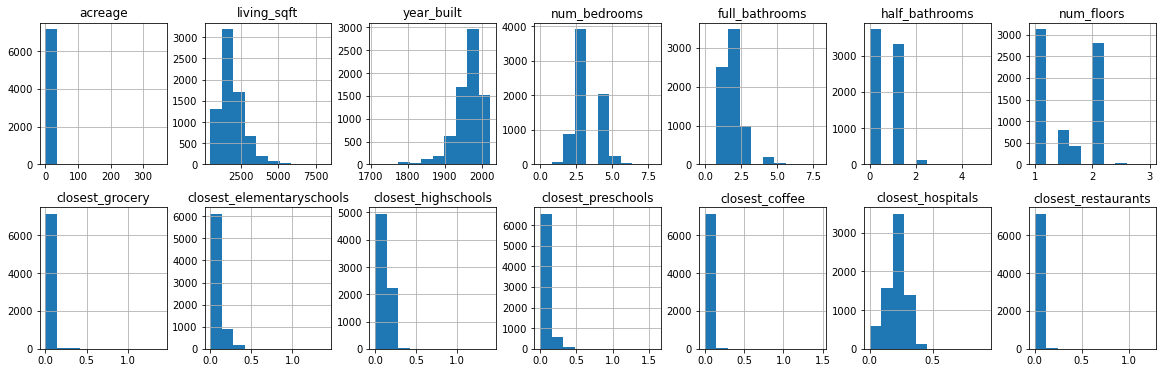

In [25]:
fig, axes = plt.subplots(ncols=len(numeric_features_log+numeric_features)//2, nrows=2, figsize=(20,6))
houses_cleaned_df[numeric_features_log + numeric_features].hist(ax=axes)
plt.show()

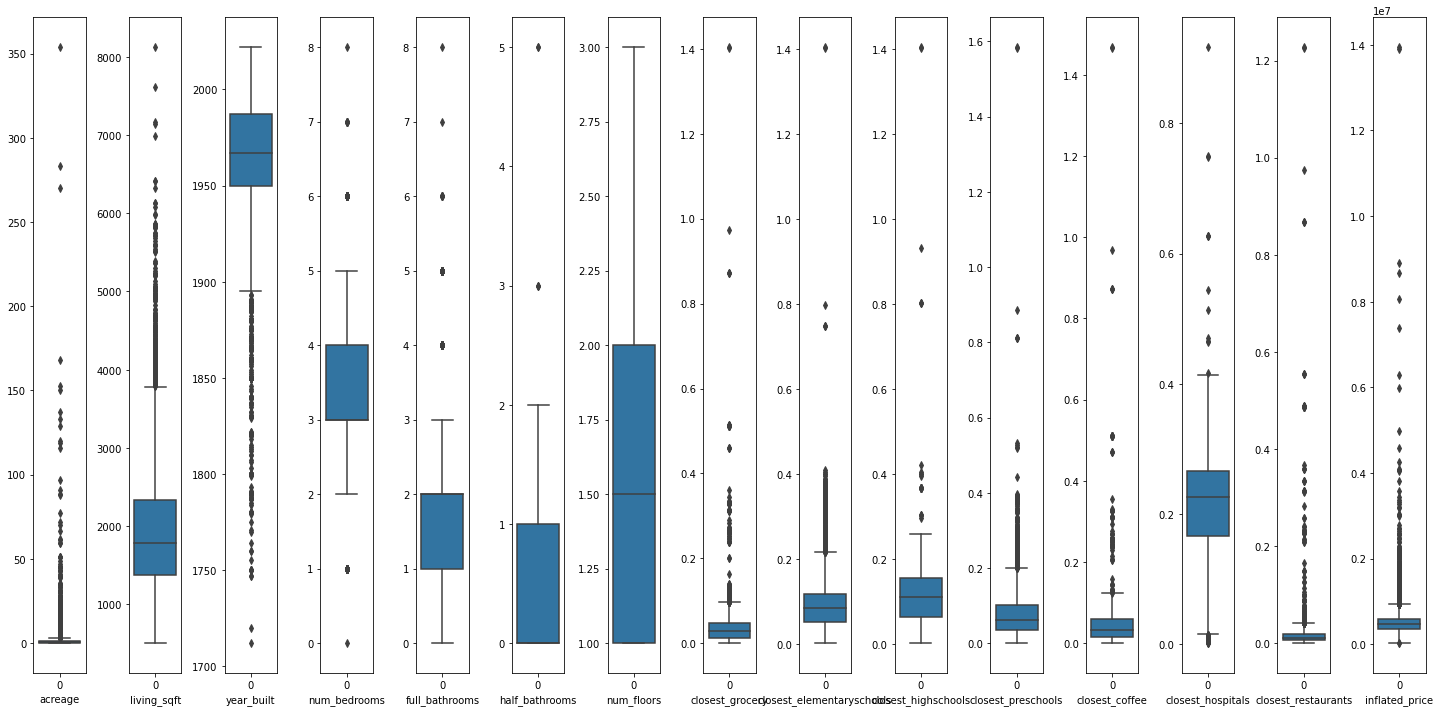

In [26]:
boxplot_features = numeric_features_log + numeric_features + ['inflated_price']
fig, ax = plt.subplots(ncols=len(boxplot_features), figsize=(20,10))
for i, feature in enumerate(boxplot_features):
    sns.boxplot(data=houses_cleaned_df[feature], ax=ax[i])
    ax[i].set_xlabel(feature)
plt.tight_layout()
plt.show()

# Remove Outliers

In [53]:
houses_cleaned_df[houses_cleaned_df['inflated_price'] < 8e5]

address_street                 town  \
0          16         Lavelle                        Rd               Amenia   
1          7          Mountain View                  Rd               Amenia   
2          425        Leedsville                     Rd               Amenia   
3          350        Leedsville                     Rd               Amenia   
4          360        Bog Hollow                     Rd               Amenia   
...                                                 ...                  ...   
7204      25         Clapp                          Ave  V. Wappingers Falls   
7205    E  20         Academy                        St  V. Wappingers Falls   
7206  S  20         Gilmore                        Blvd  V. Wappingers Falls   
7207       20         Prospect                       St  V. Wappingers Falls   
7208   S  56         Remsen                         Ave  V. Wappingers Falls   

                parcel_id           sale_date  sale_price building_style  \
0     7167-13-145335-0000 2022-03-01 11:20:46    165000.0      Old style   
1     7168-00-269071-0000 2022-02-24 13:05:54    392000.0   Raised ranch   
2     7267-00-407485-0000 2022-02-18 12:53:21    190000.0          Ranch   
3     7267-00-432304-0000 2022-02-18 12:51:49    260000.0       Log home   
4     7264-00-244626-0000 2022-02-15 13:23:41    353000.0          Ranch   
...                   ...                 ...         ...            ...   
7204  6158-18-253139-0000 2019-11-27 14:52:40    225000.0         Duplex   
7205  6158-18-396106-0000 2019-10-28 12:34:09    269900.0      Old style   
7206  6158-80-458007-0000 2019-08-30 16:27:56    165000.0         Duplex   
7207  6158-18-290189-0000 2019-07-30 16:46:50    337000.0   Raised ranch   
7208  6158-18-403065-0000 2019-07-08 13:02:17    212000.0       Cape cod   

      acreage  living_sqft  year_built  num_bedrooms  ...       long  \
0        1.00        945.0        1935             3  ... -73.556930   
1        1.92       1344.0        1991             3  ... -73.551920   
2        0.58       1560.0        1960             3  ... -73.510190   
3        1.29        838.0        1989             2  ... -73.509080   
4        0.61       1300.0        2020             3  ... -73.517600   
...       ...          ...         ...           ...  ...        ...   
7204     0.08       2018.0        1860             4  ... -73.921460   
7205     0.17       1248.0        1875             3  ... -73.945140   
7206     0.11        864.0        1956             2  ... -73.914090   
7207     0.39       2541.0        1966             6  ... -73.920190   
7208     0.17       1033.0        1885             3  ... -73.708903   

            lat  closest_grocery  closest_elementaryschools  \
0     41.845640         0.003837                   0.354232   
1     41.865780         0.007252                   0.352799   
2     41.849375         0.041572                   0.377514   
3     41.844660         0.043919                   0.373905   
4     41.771060         0.065419                   0.306604   
...         ...              ...                        ...   
7204  41.595165         0.010846                   0.065604   
7205  41.589100         0.035216                   0.086862   
7206  41.591410         0.006011                   0.064087   
7207  41.596460         0.009511                   0.063793   
7208  40.672195         0.016326                   0.006164   

      closest_highschools closest_preschools closest_coffee closest_hospitals  \
0                0.022179           0.263617       0.004436          0.366149   
1                0.005008           0.283820       0.016375          0.366459   
2                0.040091           0.291367       0.045071          0.410694   
3                0.043171           0.288197       0.046459          0.412827   
4                0.056633           0.226789       0.060273          0.367876   
...                   ...                ...            ...

In [54]:
houses_cleaned_df = houses_cleaned_df[houses_cleaned_df['inflated_price'] > 1e5]

In [55]:
houses_cleaned_df = houses_cleaned_df[houses_cleaned_df['inflated_price'] < 8e5] #changed from 5e6

In [56]:
houses_cleaned_df = houses_cleaned_df[houses_cleaned_df['acreage'] < 50]

In [57]:
houses_cleaned_df = houses_cleaned_df[houses_cleaned_df['living_sqft'] < 5000]

In [58]:
print('df size: ' + str(len(houses_cleaned_df)))
houses_cleaned_df.head()

df size: 6475


address_street    town            parcel_id  \
0  16         Lavelle                        Rd  Amenia  7167-13-145335-0000   
1  7          Mountain View                  Rd  Amenia  7168-00-269071-0000   
2  425        Leedsville                     Rd  Amenia  7267-00-407485-0000   
3  350        Leedsville                     Rd  Amenia  7267-00-432304-0000   
4  360        Bog Hollow                     Rd  Amenia  7264-00-244626-0000   

            sale_date  sale_price building_style  acreage  living_sqft  \
0 2022-03-01 11:20:46    165000.0      Old style     1.00        945.0   
1 2022-02-24 13:05:54    392000.0   Raised ranch     1.92       1344.0   
2 2022-02-18 12:53:21    190000.0          Ranch     0.58       1560.0   
3 2022-02-18 12:51:49    260000.0       Log home     1.29        838.0   
4 2022-02-15 13:23:41    353000.0          Ranch     0.61       1300.0   

   year_built  num_bedrooms  ...      long        lat  closest_grocery  \
0        1935             3  ... -73.55693  41.845640         0.003837   
1        1991             3  ... -73.55192  41.865780         0.007252   
2        1960             3  ... -73.51019  41.849375         0.041572   
3        1989             2  ... -73.50908  41.844660         0.043919   
4        2020             3  ... -73.51760  41.771060         0.065419   

   closest_elementaryschools  closest_highschools closest_preschools  \
0                   0.354232             0.022179           0.263617   
1                   0.352799             0.005008           0.283820   
2                   0.377514             0.040091           0.291367   
3                   0.373905             0.043171           0.288197   
4                   0.306604             0.056633           0.226789   

  closest_coffee closest_hospitals  closest_restaurants  inflated_price  
0       0.004436          0.366149             0.003654   179859.601737  
1       0.016375          0.366459             0.006342   432389.401208  
2       0.045071          0.410694             0.042279   209576.495483  
3       0.046459          0.412827             0.044608   286788.888556  
4       0.060273          0.367876             0.041008   394127.768029  

[5 rows x 28 columns]

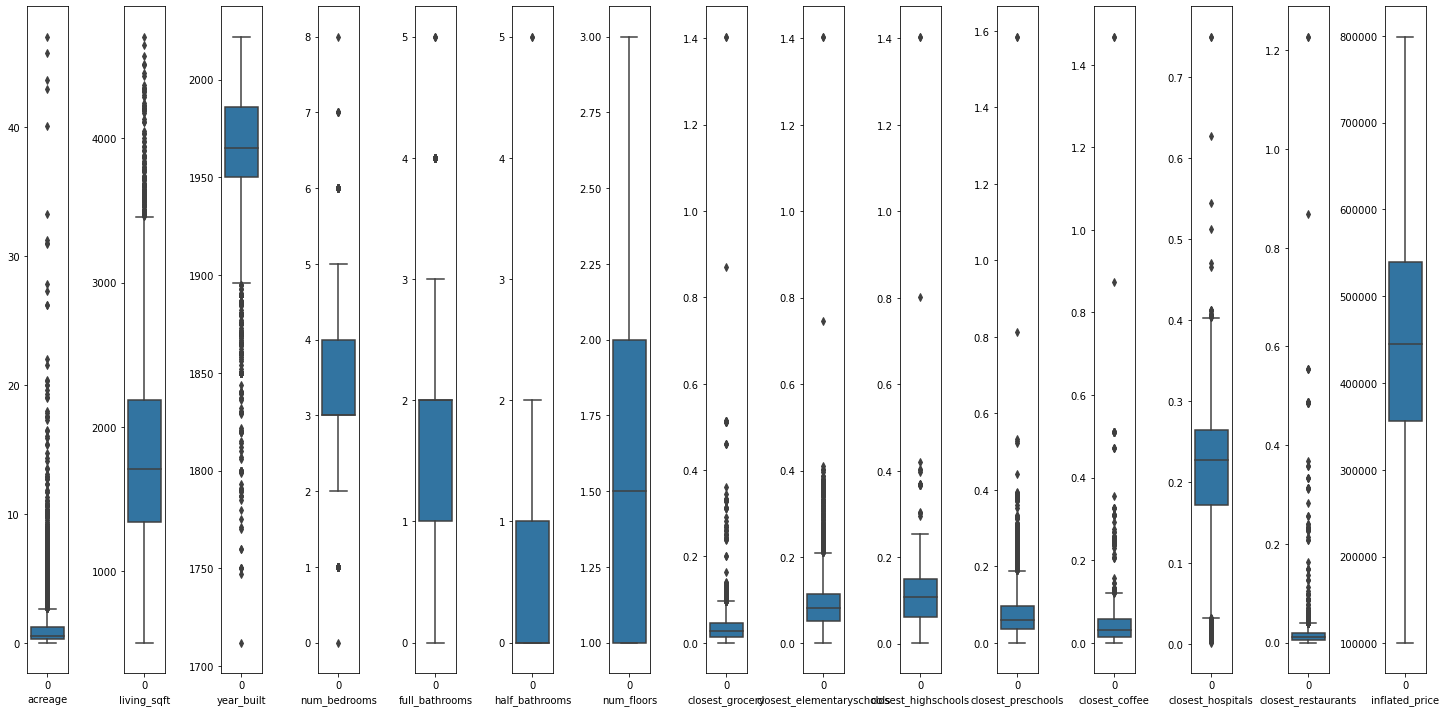

In [59]:
boxplot_features = numeric_features_log + numeric_features + ['inflated_price']
fig, ax = plt.subplots(ncols=len(boxplot_features), figsize=(20,10))
for i, feature in enumerate(boxplot_features):
    sns.boxplot(data=houses_cleaned_df[feature], ax=ax[i])
    ax[i].set_xlabel(feature)
plt.tight_layout()
plt.show()

## Pair Plot

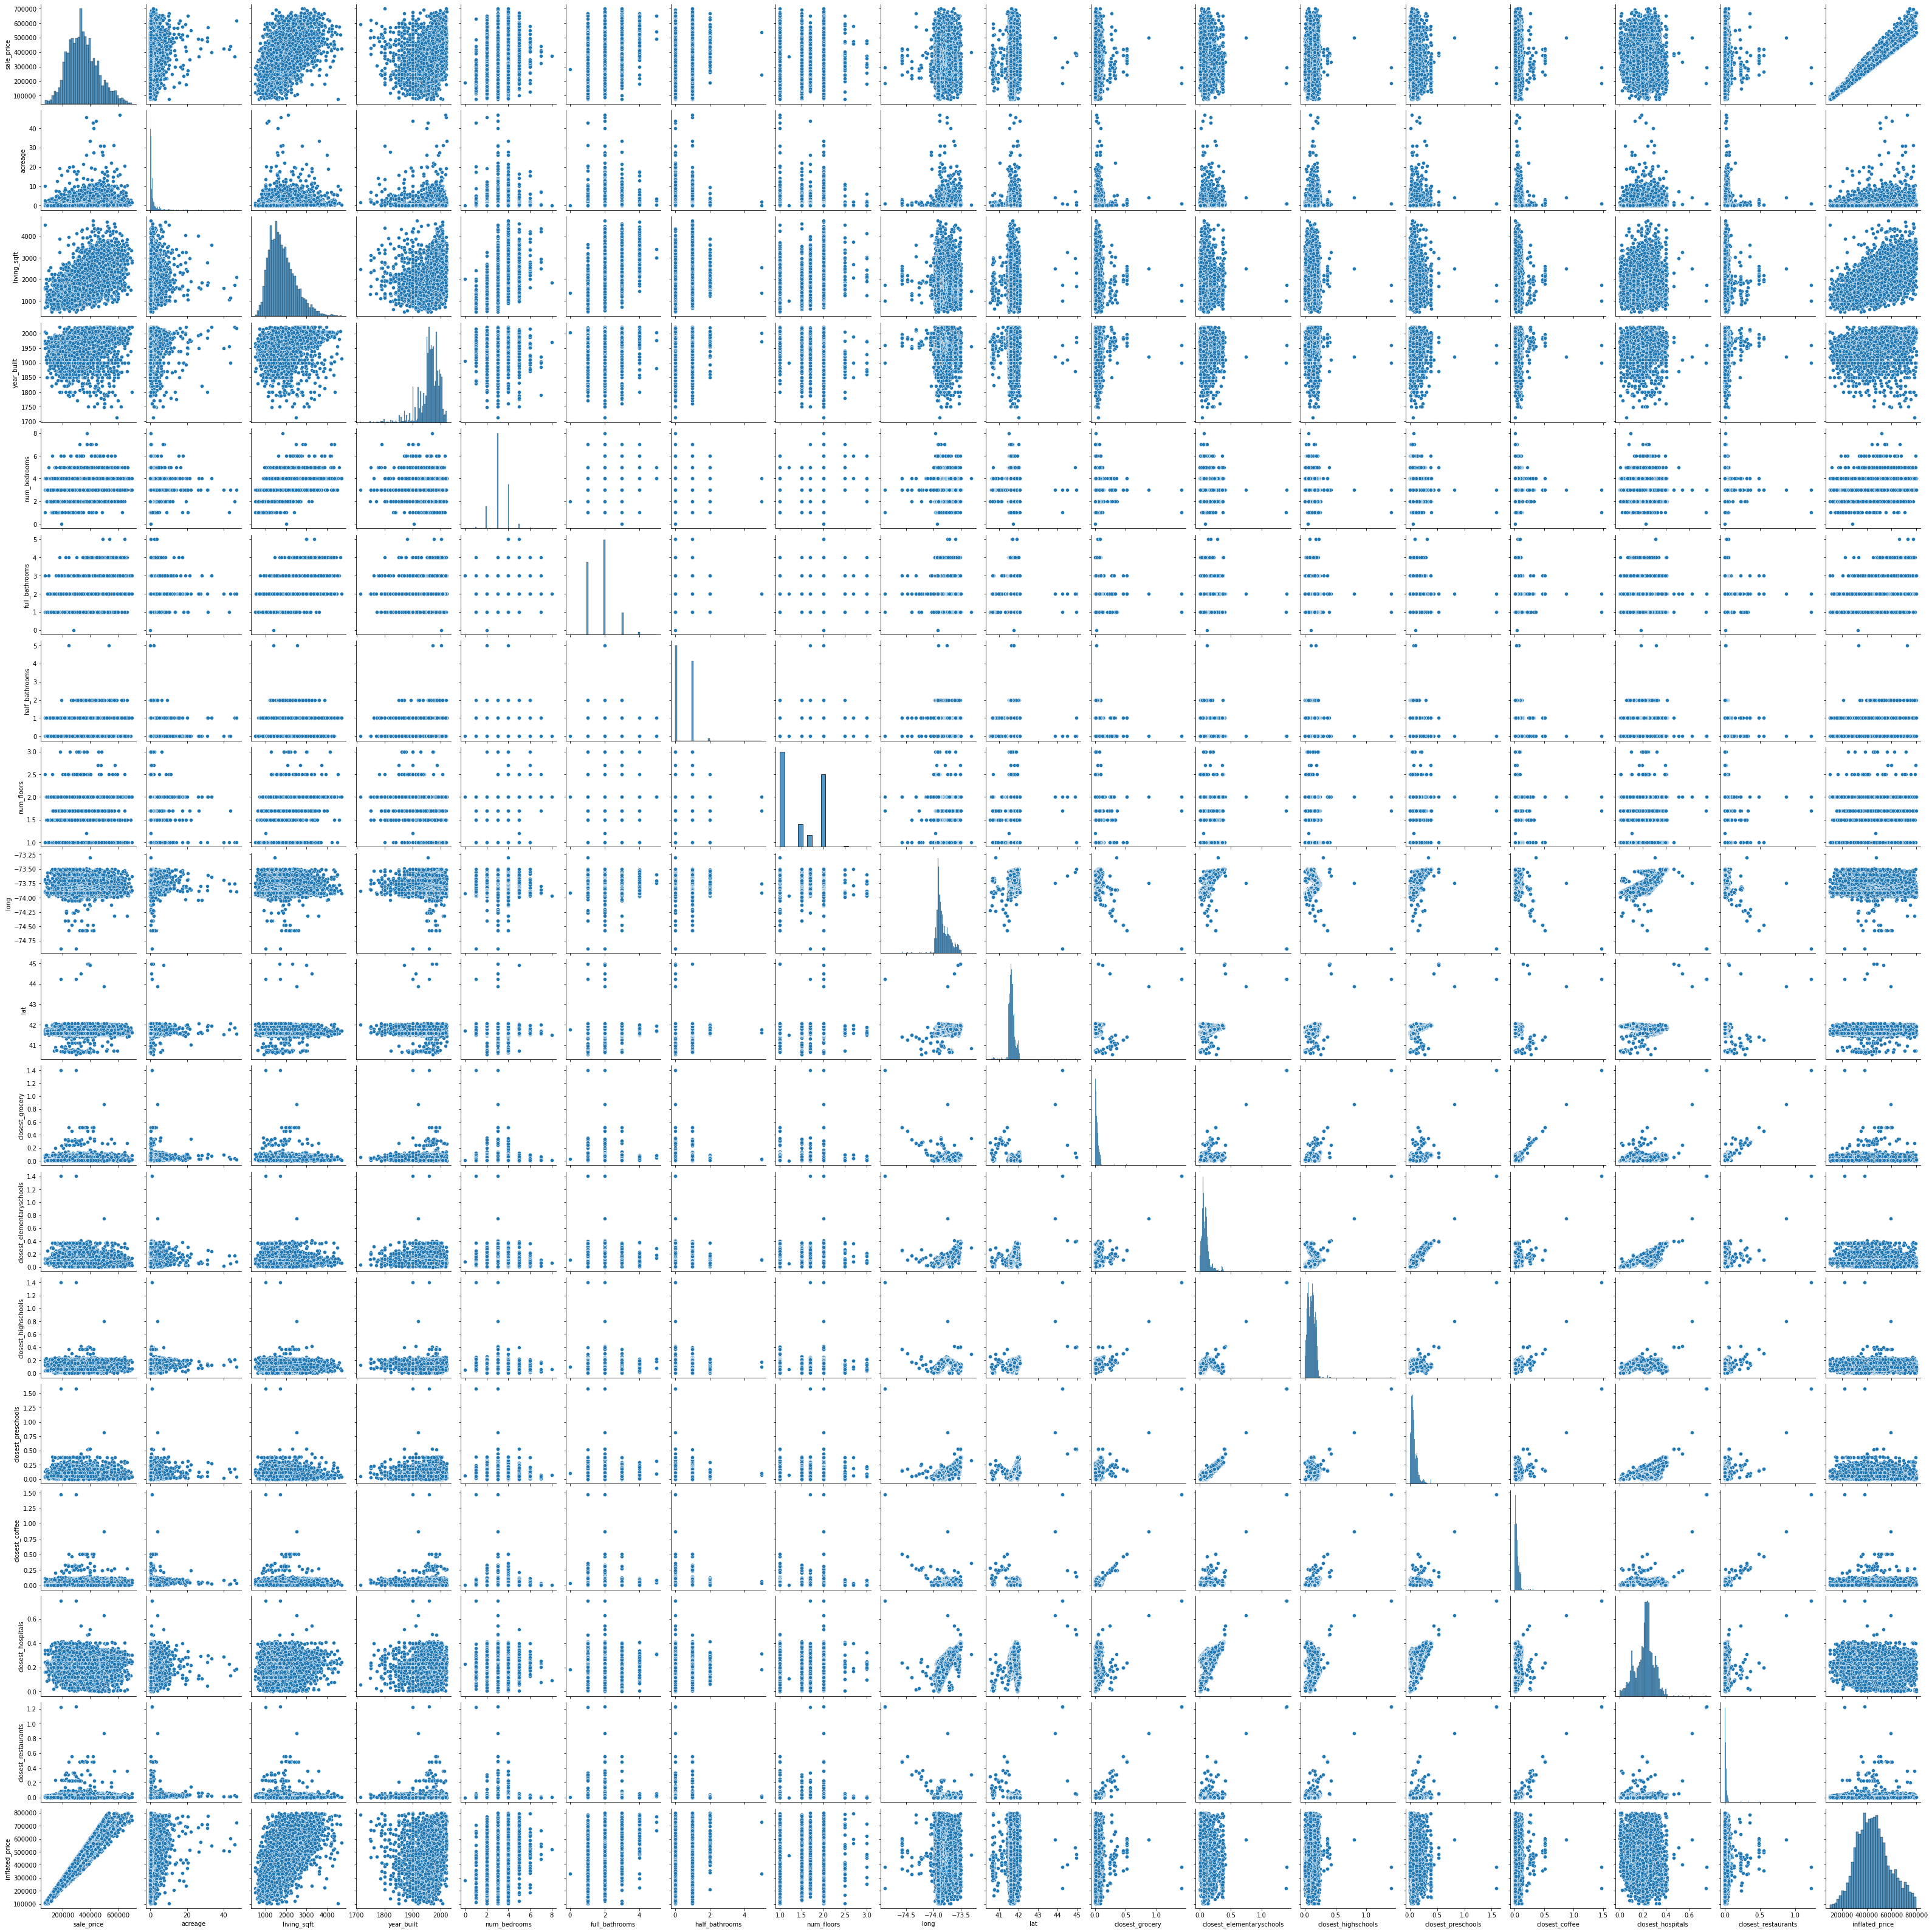

In [60]:
sns.pairplot(houses_cleaned_df)
plt.show()

## Correlation Table

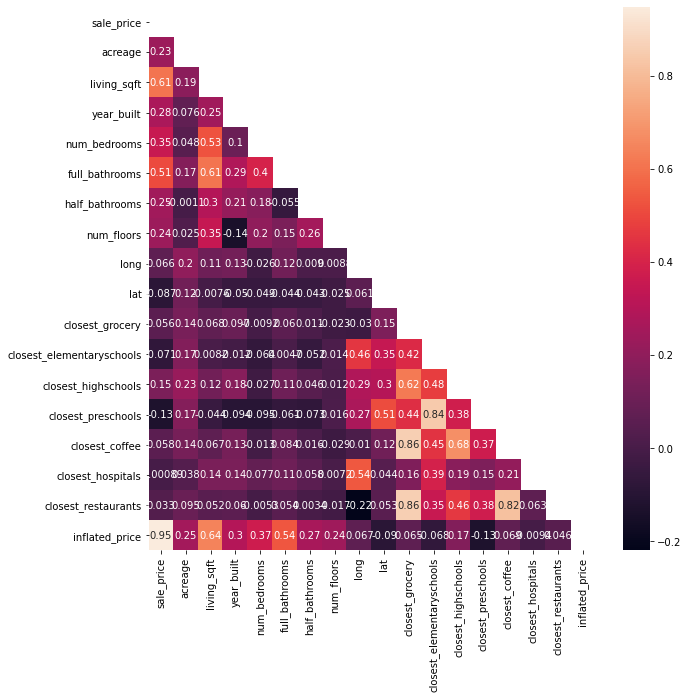

In [61]:
corr = houses_cleaned_df.corr()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr,annot=True, mask=np.triu(np.ones_like(corr)))
plt.show()

## Variance Inflation Factor

In [62]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# vif = [variance_inflation_factor(X_train[numeric_features].values, i) for i in range(X_train[numeric_features].shape[1])]
# pd.Series(vif, index=X_train[numeric_features].columns)

# Test Train Split

In [63]:
from sklearn.model_selection import train_test_split

X = houses_cleaned_df.drop(columns=['sale_price','address_street','parcel_id','sale_date','inflated_price'], axis=1)
y = np.log(houses_cleaned_df['inflated_price'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1)

# Simple Baseline Model

Based on the correlation table, we will build our baseline model by using living_sqft as our main independent variable.

In [64]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

simple_X_train = X_train[['living_sqft']]
sm.OLS(endog=y_train, exog=sm.add_constant(simple_X_train)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         inflated_price   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     2552.
Date:                Thu, 23 Jun 2022   Prob (F-statistic):               0.00
Time:                        10:31:42   Log-Likelihood:                -340.08
No. Observations:                4532   AIC:                             684.2
Df Residuals:                    4530   BIC:                             697.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.4220      0.012   1069.242      0.000      12.399      12.445
living_sqft     0.0003   6.02e-06     50.518      0.000       0.000       0.000
==============================================================================
Omnibus:                      910.254   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3241.402
Skew:                          -0.979   Prob(JB):                         0.00
Kurtosis:                       6.651   Cond. No.                     5.79e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.79e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

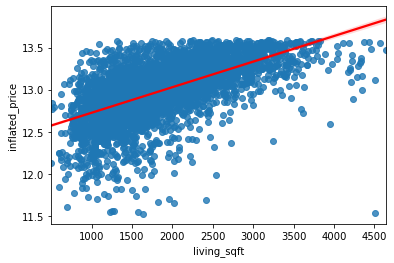

In [65]:
sns.regplot(x=simple_X_train, y=y_train, line_kws={'color': 'red'})
plt.show()

R-squared is .452. not good

# Initialize Pipeline

In [66]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, OrdinalEncoder

In [67]:

def log_transform(x):
    return np.log(x)

numeric_log_pipeline = Pipeline(steps=[
    ('log_trans', FunctionTransformer(log_transform)),
    ('scaler', StandardScaler())
])

numeric_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('one_hot', OneHotEncoder(sparse=False, drop='first'))
])

ordinal_pipeline = Pipeline(steps=[
    ('ordinal_enc', OrdinalEncoder(categories=[grade_cats, condition_cats]))
])

In [68]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(transformers=[
    ('log_number', numeric_log_pipeline, numeric_features_log),
    ('number', numeric_pipeline, numeric_features),
    ('category', categorical_pipeline, categorical_features),
    ('ordinal', ordinal_pipeline, ordinal_features)
])

In [69]:
X_train_processed = preprocessor.fit_transform(X_train)
feature_names = numeric_features_log + numeric_features + list(preprocessor.transformers_[2][1].steps[0][1].get_feature_names()) + ordinal_features
X_train_processed = pd.DataFrame(X_train_processed, columns=feature_names)              
scaled_data = pd.concat([X_train_processed, y_train.reset_index(drop=True)], axis=1)

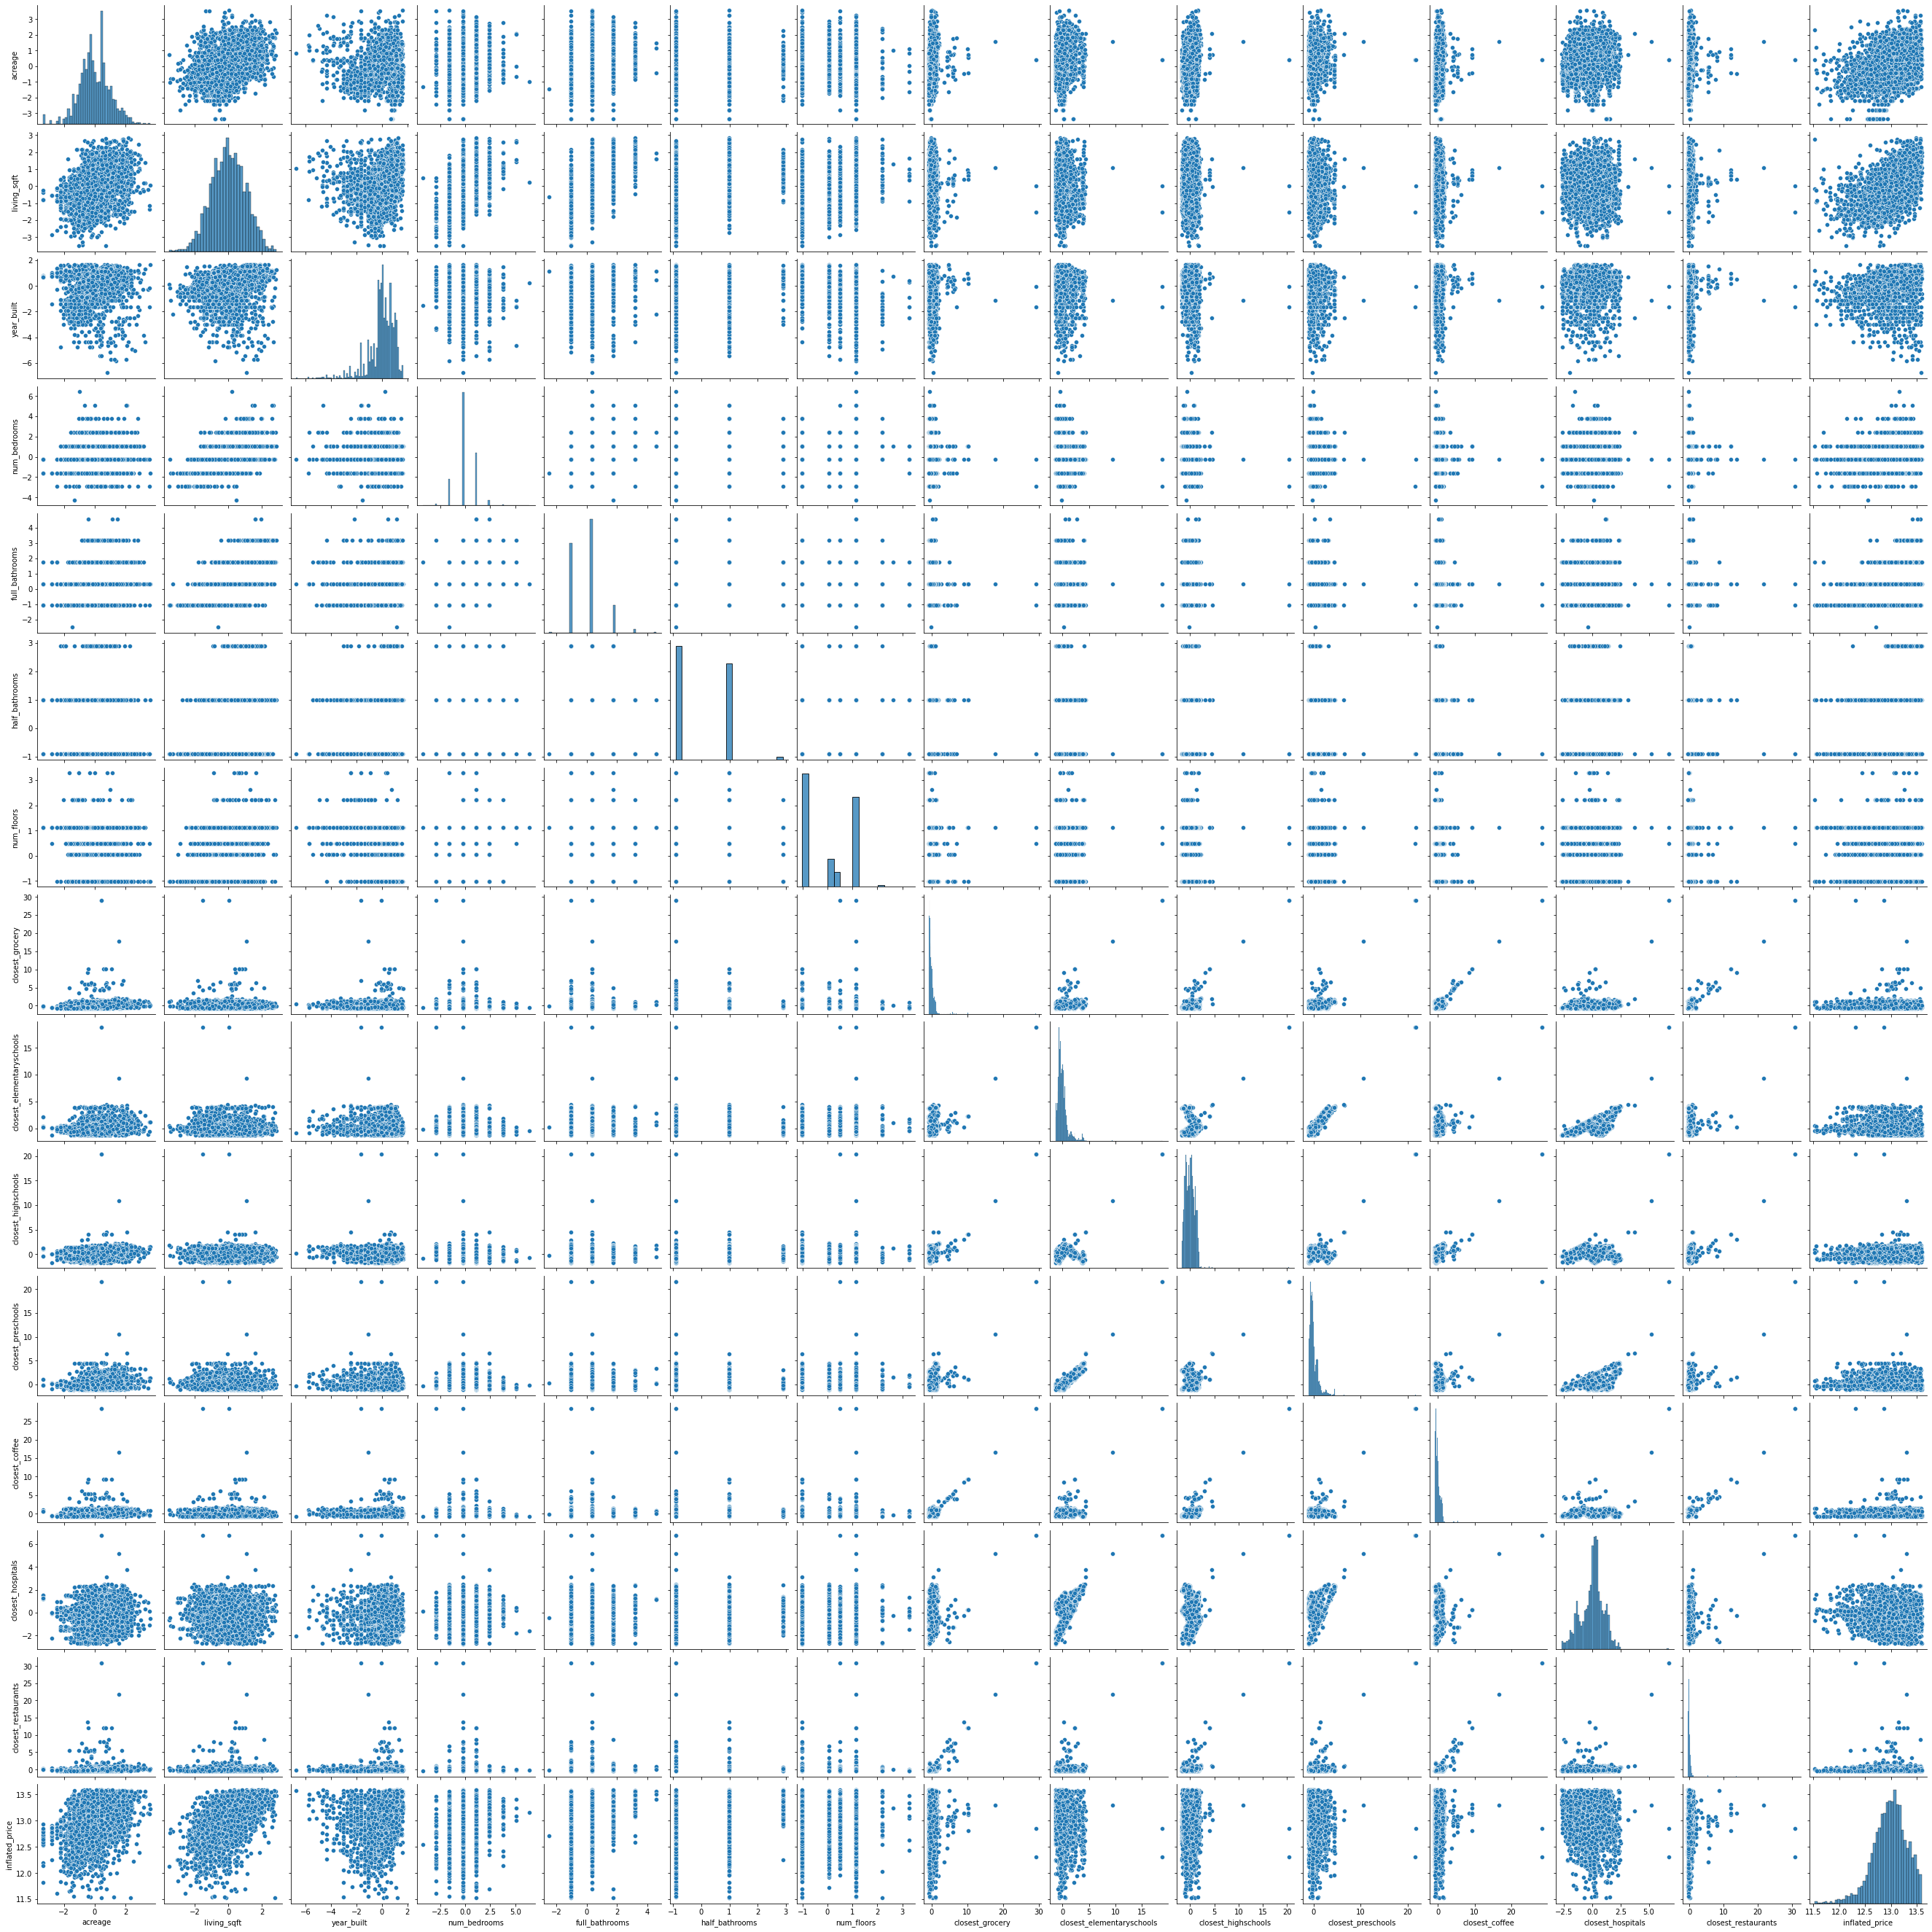

In [70]:
sns.pairplot(scaled_data[numeric_features_log + numeric_features + ['inflated_price']])
plt.show()

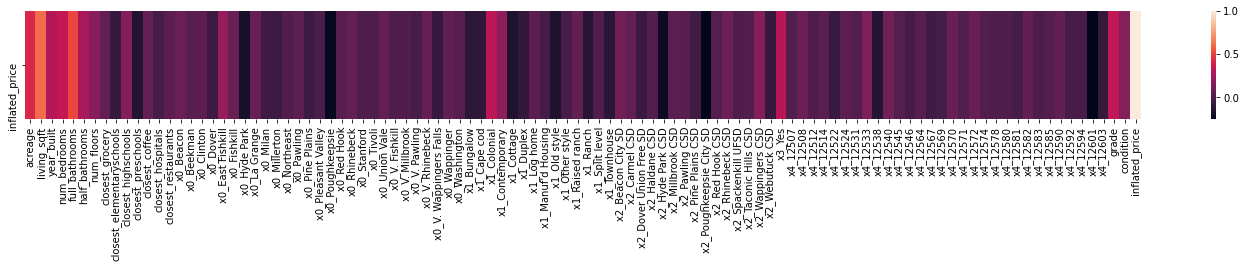

In [71]:
scaled_corr = scaled_data.corr()[['inflated_price']].T

fig, ax = plt.subplots(figsize=(25,2))
sns.heatmap(scaled_corr)
plt.show()

# Fit Multiple Linear Regression Model

In [72]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

linreg = LinearRegression()

baseline_model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', linreg)
])

baseline_model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('log_number',
                                                  Pipeline(steps=[('log_trans',
                                                                   FunctionTransformer(func=<function log_transform at 0x7f7bcb417550>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['acreage', 'living_sqft']),
                                                 ('number',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['year_built', 'num_bedrooms',
                                                   'full_bathrooms',
                                                   'half_bathrooms',

In [73]:
def print_r2_and_MSE(model, X_train, y_train, X_test, y_test):
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    train_mse = mean_squared_error(y_train, model.predict(X_train))
    test_mse = mean_squared_error(y_test, model.predict(X_test))
    
    print(f"""
Training Data:
    R2 - {train_score}
    MSE - {train_mse}
Test Data:
    R2 - {test_score}
    MSE - {test_mse}
    """)
    

In [74]:
print_r2_and_MSE(baseline_model, X_train, y_train, X_test, y_test)


Training Data:
    R2 - 0.6559970126074427
    MSE - 0.036587083662209946
Test Data:
    R2 - 0.6445133536965035
    MSE - 0.03667882676881318
    


In [75]:
sm_model = sm.OLS(endog=y_train.reset_index(drop=True), exog=X_train_processed).fit()
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         inflated_price   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.243e+05
Date:                Thu, 23 Jun 2022   Prob (F-statistic):                        0.00
Time:                        10:32:18   Log-Likelihood:                          10.661
No. Observations:                4532   AIC:                                      184.7
Df Residuals:                    4429   BIC:                                      845.8
Df Model:                         103                                                  
Covariance Type:            nonrobust                                                  
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
acreage                       0.0709      0.006     11.848      0.000       0.059       0.083
living_sqft                   0.0850      0.007     12.724      0.000       0.072       0.098
year_built                    0.0018      0.006      0.321      0.749      -0.009       0.013
num_bedrooms                  0.0031      0.005      0.658      0.511      -0.006       0.012
full_bathrooms                0.0531      0.005     10.056      0.000       0.043       0.063
half_bathrooms                0.0381      0.004      8.552      0.000       0.029       0.047
num_floors                    0.0086      0.010      0.825      0.410      -0.012       0.029
closest_grocery              -0.0134      0.014     -0.955      0.339      -0.041       0.014
closest_elementaryschools     0.1241      0.018      6.830      0.000       0.089       0.160
closest_highschools          -0.1189      0.015     -8.153      0.000      -0.148      -0.090
closest_preschools           -0.0364      0.017     -2.135      0.033      -0.070      -0.003
closest_coffee                0.0005      0.015      0.032      0.974      -0.028       0.029
closest_hospitals             0.0634      0.011      5.890      0.000       0.042       0.085
closest_restaurants           0.0287      0.012      2.468      0.014       0.006       0.052
x0_Beacon                     0.0332      0.144      0.230      0.818      -0.249       0.316
x0_Beekman                   -0.2192      0.129     -1.703      0.089      -0.472       0.033
x0_Clinton                   -0.2441      0.135     -1.809      0.071      -0.509       0.020
x0_Dover                      0.1685      0.091      1.855      0.064      -0.010       0.347
x0_East Fishkill             -0.2206      0.130     -1.702      0.089      -0.475       0.034
x0_Fishkill                  -0.1774      0.138     -1.287      0.198      -0.448       0.093
x0_Hyde Park                 -0.2939      0.132     -2.220      0.026      -0.554      -0.034
x0_La Grange                 -0.2087      0.129     -1.620      0.105      -0.461       0.044
x0_Milan                     -0.5117      0.152     -3.360      0.001      -0.810      -0.213
x0_Millerton                 -2.5114      0.185    -13.545      0.000      -2.875      -2.148
x0_Northeast                 -2.1908      0.168    -13.038      0.000      -2.520      -1.861
x0_Pawling                   -0.8956      0.128     -7.019      0.000      -1.146      -0.645
x0_Pine Plains               -1.1061      0.171     -6.485      0.000      -1.440      -0.772
x0_Pleasant Valley           -0.2114      0.133     -1.589      0.112      -0.472       0.049
x0_Poughkeepsie              -0.2806      0.129     -2.173      0.030 

ValueError: Column ordering must be equal for fit and for transform when using the remainder keyword

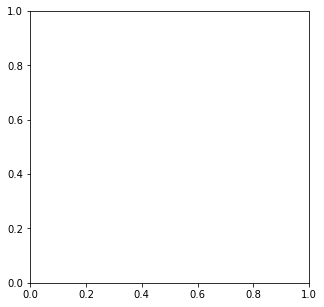

In [98]:
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(x=np.exp(baseline_model.predict(X_train)), y=np.exp(y_train.reset_index(drop=True)), ax=ax)
ax.set_title('Training Data - Predicted vs. Actual')
ax.set_xlabel('predicted price')
ax.set_ylabel('sale price')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='pink')
ax.set(xlim=(0, 1.5e6), ylim=(0, 1.5e6))
plt.show()

# Removing Some Features

Based on our results, we can try to remove some features from our X_train and X_test to see if that improves results.

In [97]:
X_train.columns

Index(['town', 'building_style', 'acreage', 'living_sqft', 'year_built',
       'num_bedrooms', 'school_district', 'central_air', 'full_bathrooms',
       'half_bathrooms', 'num_floors', 'grade', 'condition', 'zip', 'long',
       'lat', 'closest_grocery', 'closest_elementaryschools',
       'closest_highschools', 'closest_preschools', 'closest_coffee',
       'closest_hospitals', 'closest_restaurants'],
      dtype='object')

In [107]:
cols_to_drop = ['town','closest_grocery','closest_highschools', 'closest_preschools', 'closest_coffee','closest_restaurants']
X_train_pruned = X_train.drop(columns=cols_to_drop)
X_test_pruned = X_test.drop(columns=cols_to_drop)

feature_lists = [numeric_features_log, numeric_features, categorical_features, ordinal_features]

for col in cols_to_drop:
    for list_ in feature_lists:
        if col in list_:
            list_.remove(col)


pruned_preprocessor = ColumnTransformer(transformers=[
    ('log_number', numeric_log_pipeline, feature_lists[0]),
    ('number', numeric_pipeline, feature_lists[1]),
    ('category', categorical_pipeline, feature_lists[2]),
    ('ordinal', ordinal_pipeline, feature_lists[3])
])

baseline_model_pruned = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', linreg)
])

baseline_model_pruned.fit(X_train_pruned, y_train)

print_r2_and_MSE(baseline_model_pruned, X_train_pruned, y_train, X_test_pruned, y_test)



Training Data:
    R2 - 0.643035581171701
    MSE - 0.037965621040376145
Test Data:
    R2 - 0.6347195235303008
    MSE - 0.037689346302541706
    


# Adding Polynomial Features

In [108]:
from sklearn.preprocessing import PolynomialFeatures

numeric_log_pipeline_wPoly = Pipeline(steps=[
    ('log_trans', FunctionTransformer(log_transform)),
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures())
])

numeric_pipeline_wPoly = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures())
])

polypreprocessor = ColumnTransformer(transformers=[
    ('log_number', numeric_log_pipeline_wPoly, feature_lists[0]),
    ('number', numeric_pipeline_wPoly, feature_lists[1]),
    ('category', categorical_pipeline, feature_lists[2]),
    ('ordinal', ordinal_pipeline, feature_lists[3])
])

linreg = LinearRegression()

poly_model = Pipeline(steps=[
    ('preprocess', polypreprocessor),
    ('model', linreg)
])

poly_model.fit(X_train_pruned, y_train)

print_r2_and_MSE(poly_model, X_train_pruned, y_train, X_test_pruned, y_test)



Training Data:
    R2 - 0.655798235230902
    MSE - 0.036608225003338324
Test Data:
    R2 - 0.6412639015801636
    MSE - 0.03701410262940637
    


# Finding Interactions

In [111]:
from sklearn.base import TransformerMixin

preprocessor.fit(X_train_pruned)

feature_names = get_feature_names(preprocessor)

class AddOneInteraction(TransformerMixin):
    def __init__(self, i, j):
        self.i = i
        self.j = j
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_ = np.copy(X)
        # change new_feature and right member according to your needs
        interaction = X_[:,self.i] * X_[:,self.j]
        X_ = np.concatenate([X_, interaction.reshape(-1,1)], axis=1)
        
        return X_

interactions = {}
for i in range(len(feature_names)):
    for j in range(len(feature_names)):
        if (i != j) and (frozenset((i,j)) not in interactions_not_poly.keys()):
            interaction = AddOneInteraction(i,j)
            interaction_model = Pipeline(steps=[
                ('preprocess', preprocessor),
                ('interaction', interaction),
                ('model', linreg)
            ])

            interaction_model.fit(X_train, y_train)
            train_score = interaction_model.score(X_train, y_train)
            test_score = interaction_model.score(X_test, y_test)
            
            interactions[frozenset((i,j))] = (train_score, test_score, feature_names[i], feature_names[j],i,j)
    print(f'{i+1} / {len(feature_names)}', end='\r')

         

/Users/michaelroth/Documents/Flatiron/Projects/Housing-Data-Linear-Regression/getFeatureNames.py:33: UserWarning: Transformer log_trans (type FunctionTransformer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
/Users/michaelroth/Documents/Flatiron/Projects/Housing-Data-Linear-Regression/getFeatureNames.py:33: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
/Users/michaelroth/Documents/Flatiron/Projects/Housing-Data-Linear-Regression/getFeatureNames.py:33: UserWarning: Transformer ordinal_enc (type OrdinalEncoder) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


In [112]:
def sort_by_test(x):
    return x[1]

interactions_to_use = sorted(list(interactions.values()), key=sort_by_test, reverse=True)[:20]
[x[-4:-2] for x in interactions_to_use]

[('ordinal__grade', 'number__full_bathrooms'),
 ('one_hot__x3_12508', 'one_hot__x2_Yes'),
 ('ordinal__condition', 'number__year_built'),
 ('one_hot__x1_Poughkeepsie City SD', 'number__full_bathrooms'),
 ('one_hot__x1_Rhinebeck CSD', 'one_hot__x0_Old style'),
 ('ordinal__grade', 'one_hot__x2_Yes'),
 ('one_hot__x2_Yes', 'one_hot__x1_Beacon City SD'),
 ('one_hot__x3_12569', 'one_hot__x0_Old style'),
 ('one_hot__x1_Poughkeepsie City SD', 'number__num_floors'),
 ('one_hot__x3_12572', 'one_hot__x0_Old style'),
 ('number__full_bathrooms', 'number__num_bedrooms'),
 ('one_hot__x1_Rhinebeck CSD', 'number__year_built'),
 ('one_hot__x3_12601', 'number__full_bathrooms'),
 ('ordinal__condition', 'one_hot__x3_12508'),
 ('one_hot__x2_Yes', 'one_hot__x1_Poughkeepsie City SD'),
 ('one_hot__x1_Beacon City SD', 'one_hot__x0_Old style'),
 ('ordinal__grade', 'one_hot__x0_Old style'),
 ('one_hot__x1_Red Hook CSD', 'number__year_built'),
 ('one_hot__x3_12545', 'number__full_bathrooms'),
 ('one_hot__x3_12601',

In [113]:
#make a list from the dictionary of interactions and take the last two values from each tuple (i, j)
list_of_ijs = [x[-2:] for x in interactions_to_use]

In [114]:
class AddMultInteraction(TransformerMixin):
    def __init__(self, list_of_ij_tuples):
        self.ijs = list_of_ijs
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_ = np.copy(X)
        # change new_feature and right member according to your needs
        for x in self.ijs:
            interaction = X_[:,x[0]] * X_[:,x[1]]
            X_ = np.concatenate([X_, interaction.reshape(-1,1)], axis=1)
        
        return X_

mult_interaction = AddMultInteraction(list_of_ijs)
mult_interaction_model = Pipeline(steps=[
    ('preprocess', polypreprocessor),
    ('interaction', mult_interaction),
    ('model', linreg)
])

mult_interaction_model.fit(X_train, y_train)

print_r2_and_MSE(mult_interaction_model, X_train, y_train, X_test, y_test)



Training Data:
    R2 - 0.6316853375559561
    MSE - 0.03917279751260206
Test Data:
    R2 - 0.5926170344612192
    MSE - 0.04203344732337803
    


# RFECV

does not help

In [120]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

class RFECV_Support(TransformerMixin):
    def __init__(self):
        self.selected_features = []
    
    def fit(self, X, y=None):
        X_ = np.copy(X)
        linreg = LinearRegression()

        mult_interaction_processor = Pipeline(steps=[
            ('preprocess', preprocessor),
            ('interaction', mult_interaction)
        ])

        inner_kv = KFold(n_splits=5, shuffle=True, random_state=42)
        rfcv = RFECV(estimator=linreg, step=1, cv=inner_kv, scoring="neg_mean_squared_error")

        rfcv.fit(mult_interaction_processor.fit_transform(X_), y)
        
        X_processed = mult_interaction_processor.fit_transform(X_)
        
        X_processed = pd.DataFrame(X_processed)
        
        self.selected_features = rfcv.get_support(1)
        X_processed = X_processed[X_processed.columns[selected_features]]
        
        return self.X_processed
        
    def transform(self, X, y=None):
        X_ = X.copy()
        X_ = pd.DataFrame(X_)
        X_processed = X_[X_.columns[self.selected_features]]
        
        return X_processed

In [121]:
add_RFECV_support = RFECV_Support()
RFECV_support_model = Pipeline(steps=[
    ('preprocess', polypreprocessor),
    ('interaction', mult_interaction),
    ('rfecv', add_RFECV_support),
    ('model', linreg)
])

RFECV_support_model.fit(X_train_pruned, y_train)

print_r2_and_MSE(RFECV_support_model, X_train_pruned, y_train, X_test_pruned, y_test)


ValueError: Specifying the columns using strings is only supported for pandas DataFrames

In [ ]:


linreg = LinearRegression()

mult_interaction_processor = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('interaction', mult_interaction)
])

inner_kv = KFold(n_splits=5, shuffle=True, random_state=42)
rfcv = RFECV(estimator=linreg, step=1, cv=inner_kv, scoring="neg_mean_squared_error")

rfcv.fit(mult_interaction_processor.fit_transform(X_train), y_train)

In [ ]:
X_processed = mult_interaction_processor.fit_transform(X_train)
#feature_names = get_feature_names(X_processed)
X_processed = pd.DataFrame(X_processed)

In [ ]:
selected_features = rfcv.get_support(1)
X_processed = X_processed[X_processed.columns[selected_features]]

In [ ]:
lr = LinearRegression()

lr.fit(X_processed, y_train)

In [ ]:
lr.score(X_processed, y_train)

In [ ]:
X_test_processed = pd.DataFrame(mult_interaction_processor.transform(X_test))
X_test_processed = X_test_processed[X_test_processed.columns[selected_features]]
lr.score(X_test_processed, y_test)

# Predictions

In [ ]:
preds_train = mult_interaction_model.predict(X_train)
preds_test = mult_interaction_model.predict(X_test)

y_train_reset = y_train.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

residuals_train = preds_train - y_train_reset
residuals_test = preds_test - y_test_reset



In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
sns.scatterplot(x=preds_train, y=y_train_reset, ax=ax[0])
ax[0].set_title('Training Data - Predicted vs. Actual')
ax[0].set_xlabel('predicted price')
ax[0].set_ylabel('sale price')
ax[0].plot([0, 1], [0, 1], transform=ax[0].transAxes, color='pink')
sns.scatterplot(x=preds_test, y=y_test_reset, ax=ax[1])
ax[1].set_title('Test Data - Predicted vs. Actual')
ax[1].set_xlabel('predicted price')
ax[1].set_ylabel('sale price')
ax[1].plot([0, 1], [0, 1], transform=ax[1].transAxes, color='pink')
ax[0].set(xlim=(10, 17), ylim=(10, 17))
ax[1].set(xlim=(10, 17), ylim=(10, 17))
plt.show()

In [ ]:
X_train_preds_sorted = pd.DataFrame(preds_train).reindex(index=y_train.reset_index(drop=True).sort_values().index).reset_index(drop=True)
y_train_sorted = y_train_reset.sort_values().reset_index(drop=True)
sorted_train_residuals = X_train_preds_sorted[0] - y_train_sorted

X_test_preds_sorted = pd.DataFrame(preds_test).reindex(index=y_test.reset_index(drop=True).sort_values().index).reset_index(drop=True)
y_test_sorted = y_test_reset.sort_values().reset_index(drop=True)
sorted_test_residuals = X_test_preds_sorted[0] - y_test_sorted


In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
sns.scatterplot(x=np.linspace(y_train_sorted.min(), y_train_sorted.max(), num=len(y_train_sorted)), y=sorted_train_residuals, ax=ax[0], hue=sorted_train_residuals, palette='flare')
norm = plt.Normalize(sorted_train_residuals.min(), sorted_train_residuals.max())
sm = plt.cm.ScalarMappable(cmap="flare", norm=norm)
sm.set_array([])
ax[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax[0].set_title('Training Residuals')
ax[0].axhline(y=0, color='pink')
ax[0].set_xlabel('Sale Prices Sorted from Least to Greatest')
ax[0].set_ylabel('Predicted Error')
ax[0].get_legend().remove()
sns.scatterplot(x=np.linspace(np.exp(y_test_sorted.min()), np.exp(y_test_sorted.max()), num=len(y_test_sorted)), y=sorted_test_residuals, ax=ax[1], hue=sorted_test_residuals, palette='flare')
ax[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax[1].set_title('Testing Residuals')
ax[1].axhline(y=0, color='pink')
ax[1].set_xlabel('Sale Prices Sorted from Least to Greatest')
ax[1].set_ylabel('Predicted Error')
ax[1].get_legend().remove()
plt.show()

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
sns.scatterplot(x=np.exp(y_train_sorted), y=sorted_train_residuals, ax=ax[0], hue=sorted_train_residuals, palette='flare')
norm = plt.Normalize(sorted_train_residuals.min(), sorted_train_residuals.max())
sm = plt.cm.ScalarMappable(cmap="flare", norm=norm)
sm.set_array([])
ax[0].set_title('Training Residuals')
ax[0].axhline(y=0, color='pink')
ax[0].set_xlabel('Actual Sale Price')
ax[0].set_ylabel('Predicted Error')
ax[0].get_legend().remove()
ax[0].xaxis.set_major_formatter('${x:1.0f}')
ax[0].set_xticks(np.linspace(0, 5e6, 6))
sns.scatterplot(x=np.exp(y_test_sorted), y=sorted_test_residuals, ax=ax[1], hue=sorted_test_residuals, palette='flare')
ax[1].set_title('Testing Residuals')
ax[1].axhline(y=0, color='pink')
ax[1].set_xlabel('Acutal Sale Price')
ax[1].set_ylabel('Predicted Error')
ax[1].get_legend().remove()
ax[1].xaxis.set_major_formatter('${x:1.0f}')
ax[1].set_xticks(np.linspace(0, 5e6, 6))
plt.show()